# Homework 3

## Part 1: Imbalanced Dataset
This part of homework helps you practice to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. 

### Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

Due Date : TBD

### Name: Rakshith Kamath

### UNI: rk3165

## 0 Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate
from imblearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve,auc,average_precision_score


## 1 Data processing and exploration
Download the Kaggle Credit Card Fraud data set. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 1.1 Examine the class label imbalance
Let's look at the dataset imbalance:

**Q1. How many observations are there in this dataset? How many of them have positive label (labeled as 1)?**

In [3]:
# Your Code Here
print(f'The number of observations in this dataset is: {raw_df.shape[0]}')
class_count=raw_df.groupby(['Class'])['Class'].count()
print(f'Out of which, count for class 0 is :{class_count[0]}')
print(f'and count for class 1 is: {class_count[1]}')

The number of observations in this dataset is: 284807
Out of which, count for class 0 is :284315
and count for class 1 is: 492


### 1.2 Clean, split and normalize the data
The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [4]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

**Q2. Split the dataset into development and test sets. Please set test size as 0.2 and random state as 42.**

In [5]:
# Your Code Here
class_y = cleaned_df['Class']
cleaned_df.pop('Class')
cleaned_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log Ammount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.248367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.260067
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,3.210481
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,4.217756
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,2.302685


In [6]:
X_dev, X_test, y_dev, y_test = train_test_split(cleaned_df, class_y,
                                                stratify=class_y, 
                                                test_size=0.2,
                                                random_state=42)
features = raw_df.columns

**Q3. Normalize the input features using the sklearn StandardScaler. Print the shape of your development features and test features.**

In [7]:
# Your Code Here
preprocess= StandardScaler()
X_dev = preprocess.fit_transform(X_dev,y_dev)
X_test = preprocess.transform(X_test)
print(f'Shape of the development features matrix {X_dev.shape}')
print(f'Shape of the test features matrix {X_test.shape}')

Shape of the development features matrix (227845, 29)
Shape of the test features matrix (56962, 29)


### 1.3 Define the model and metrics
**Q4. First, fit a default logistic regression model. Print the AUC and average precision of 5-fold cross validation.**

In [8]:
# Your Code Here
# Fitting the logistic model
scores_logReg= cross_validate(LogisticRegression(),
                       X_dev,y_dev,cv=5,
                       scoring=['roc_auc','average_precision'],
                       return_estimator= True)
print(f"AUC score-{scores_logReg['test_roc_auc']}")
print(f"Average Precision score-{scores_logReg['test_average_precision']}")
print(f"Mean AUC score-{scores_logReg['test_roc_auc'].mean()}")
print(f"Mean Average Precision score-{scores_logReg['test_average_precision'].mean()}")

AUC score-[0.96867681 0.98255313 0.96207234 0.97842981 0.99011106]
Average Precision score-[0.71409904 0.80728214 0.75702807 0.78032053 0.75127881]
Mean AUC score-0.9763686302709351
Mean Average Precision score-0.7620017185050845


In this case there are 5 models with the scores of each for various metrics as shown above. We select the model for further study based on the model that gave us the maximum AUC score. Given this assumption, we calculate and check to get the index of the best model from the given set of 5 models.We have done this after consultation with TA.

In [9]:
log_best_index=np.argmax(scores_logReg['test_roc_auc'])

**Q5.1. Perform random under sampling on the development set. What is the shape of your development features? How many  positive and negative labels are there in your development set? (Please set random state as 42 when performing random under sampling)**

In [10]:
# Your Code Here
rus = RandomUnderSampler(random_state=42,replacement=False)
X_under, y_under = rus.fit_resample(X_dev, y_dev)
print(f'Shape of the development features matrix {X_under.shape}')
y_under= np.array(y_under)
non_zero_count = np.count_nonzero(y_under)
print(f'Out of which, count for class 0 is :{len(y_under)-non_zero_count}')
print(f'and count for class 1 is: {non_zero_count}')

Shape of the development features matrix (788, 29)
Out of which, count for class 0 is :394
and count for class 1 is: 394


**Q5.2. Fit a default logistic regression model using under sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random under sampling)**

In [11]:
pipe = imb_make_pipeline(rus,LogisticRegression())
scores_under = cross_validate(pipe,
                       X_dev,y_dev,cv=5,
                       scoring=['roc_auc','average_precision'],
                       return_estimator= True)
print(f"AUC score-{scores_under['test_roc_auc']}")
print(f"Average Precision score-{scores_under['test_average_precision']}")
print(f"Mean AUC score-{scores_under['test_roc_auc'].mean()}")
print(f"Mean Average Precision score-{scores_under['test_average_precision'].mean()}")

AUC score-[0.96614574 0.9753319  0.98044194 0.97379755 0.99099009]
Average Precision score-[0.4157943  0.5793424  0.68637623 0.50700442 0.65541667]
Mean AUC score-0.9773414443783114
Mean Average Precision score-0.5687868062162817


In this case there are 5 models with the scores of each for various metrics as shown above. We select the model for further study based on the model that gave us the maximum AUC score. Given this assumption, we calculate and check to get the index of the best model from the given set of 5 models.

In [12]:
under_best_index=np.argmax(scores_under['test_roc_auc'])
under_best_index

4

**Q6.1. Perform random over sampling on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing random over sampling)**

In [13]:
# Your Code Here
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_dev, y_dev)
print(f'Shape of the development features matrix {X_over.shape}')
y_over= np.array(y_over)
non_zero_count = np.count_nonzero(y_over)
print(f'Out of which, count for class 0 is :{len(y_over)-non_zero_count}')
print(f'and count for class 1 is: {non_zero_count}')

Shape of the development features matrix (454902, 29)
Out of which, count for class 0 is :227451
and count for class 1 is: 227451


**Q6.2. Fit a default logistic regression model using over sampling. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing random over sampling)**

In [14]:
pipe = imb_make_pipeline(ros,LogisticRegression())
scores_over = cross_validate(pipe,
                       X_dev,y_dev,cv=5,
                       scoring=['roc_auc','average_precision'],
                       return_estimator= True)
print(f"AUC score-{scores_over['test_roc_auc']}")
print(f"Average Precision score-{scores_over['test_average_precision']}")
print(f"Mean AUC score-{scores_over['test_roc_auc'].mean()}")
print(f"Mean Average Precision score-{scores_over['test_average_precision'].mean()}")

AUC score-[0.95932134 0.98132348 0.98764035 0.98166547 0.99338205]
Average Precision score-[0.6735306  0.79915095 0.77385311 0.75048332 0.76430859]
Mean AUC score-0.9806665368543067
Mean Average Precision score-0.7522653129344974


In this case there are 5 models with the scores of each for various metrics as shown above. We select the model for further study based on the model that gave us the maximum AUC score. Given this assumption, we calculate and check to get the index of the best model from the given set of 5 models.

In [15]:
over_best_index=np.argmax(scores_over['test_roc_auc'])
over_best_index

4

**Q7.1. Perform Synthetic Minority Oversampling Technique (SMOTE) on the development set. What is the shape of your development features? How many positive and negative labels are there in your development set? (Please set random state as 42 when performing SMOTE)**

In [16]:
# Your Code Here
smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X_dev, y_dev)
print(f'Shape of the development features matrix {X_smote.shape}')
y_smote= np.array(y_smote)
non_zero_count = np.count_nonzero(y_smote)
print(f'Out of which, count for class 0 is :{len(y_smote)-non_zero_count}')
print(f'and count for class 1 is: {non_zero_count}')

Shape of the development features matrix (454902, 29)
Out of which, count for class 0 is :227451
and count for class 1 is: 227451


**Q7.2. Fit a default logistic regression model using SMOTE. Print the AUC and average precision of 5-fold cross validation. (Please set random state as 42 when performing SMOTE)**

In [17]:
# Your Code Here
pipe = imb_make_pipeline(smote,LogisticRegression())
scores_smote=cross_validate(pipe,
                       X_dev,y_dev,cv=5,
                       scoring=['roc_auc','average_precision'],
                       return_estimator= True)
print(f"AUC score-{scores_smote['test_roc_auc']}")
print(f"Average Precision score-{scores_smote['test_average_precision']}")
print(f"Mean AUC score-{scores_smote['test_roc_auc'].mean()}")
print(f"Mean Average Precision score-{scores_smote['test_average_precision'].mean()}")

AUC score-[0.95776313 0.97980138 0.98119548 0.97971317 0.99339012]
Average Precision score-[0.67287249 0.8029996  0.76957041 0.74653647 0.76272161]
Mean AUC score-0.9783726532901543
Mean Average Precision score-0.7509401146877034


In this case there are 5 models with the scores of each for various metrics as shown above. We select the model for further study based on the model that gave us the maximum AUC score. Given this assumption, we calculate and check to get the index of the best model from the given set of 5 models.

In [18]:
smote_best_index=np.argmax(scores_smote['test_roc_auc'])
smote_best_index

4

**Q8. Plot confusion matrices on the test set for all four models above. Comment on your result.**

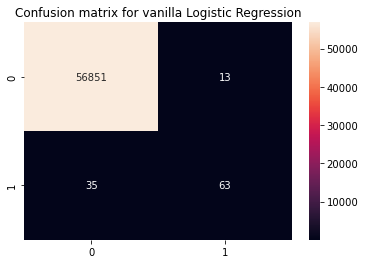

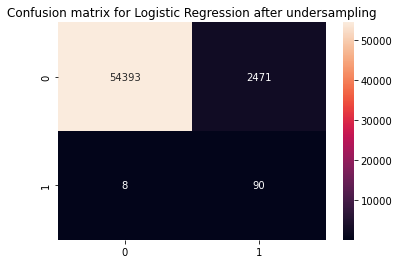

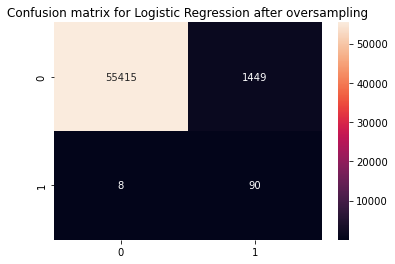

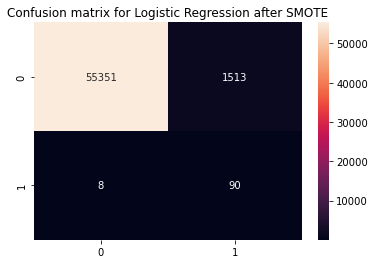

In [19]:
# Your Code Here
y_pred=scores_logReg['estimator'][log_best_index].predict(X_test)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='g')
plt.title("Confusion matrix for vanilla Logistic Regression")
plt.show()

y_pred=scores_under['estimator'][under_best_index].predict(X_test)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='g')
plt.title("Confusion matrix for Logistic Regression after undersampling")
plt.show()


y_pred=scores_over['estimator'][over_best_index].predict(X_test)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='g')
plt.title("Confusion matrix for Logistic Regression after oversampling")
plt.show()


y_pred=scores_smote['estimator'][smote_best_index].predict(X_test)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='g')
plt.title("Confusion matrix for Logistic Regression after SMOTE")
plt.show()

We notice that as we use sampling techniques such as oversampling, undersampling or SMOTE the correct prediction of the minority class increases from the vanilla logistic regression. But we also see an increase in False Positives which is a consequence of doing this.We also notice the False negative values decrease after sampling from 35 to 8. This is key for our problem of credit card fraud detection, where the number of false negatives should be low, i.e., model should reduce the number of times fraud is classified as "no fraud".
At the same time we should also keep an eye on False positives aswell. For undersampled data the False positives are higher than that of oversampling and SMOTE.False positive results in card getting blocked for transactions that are not actually fraud.

**Q9. Plot the ROC for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

Text(0, 0.5, 'True Positive Rate')

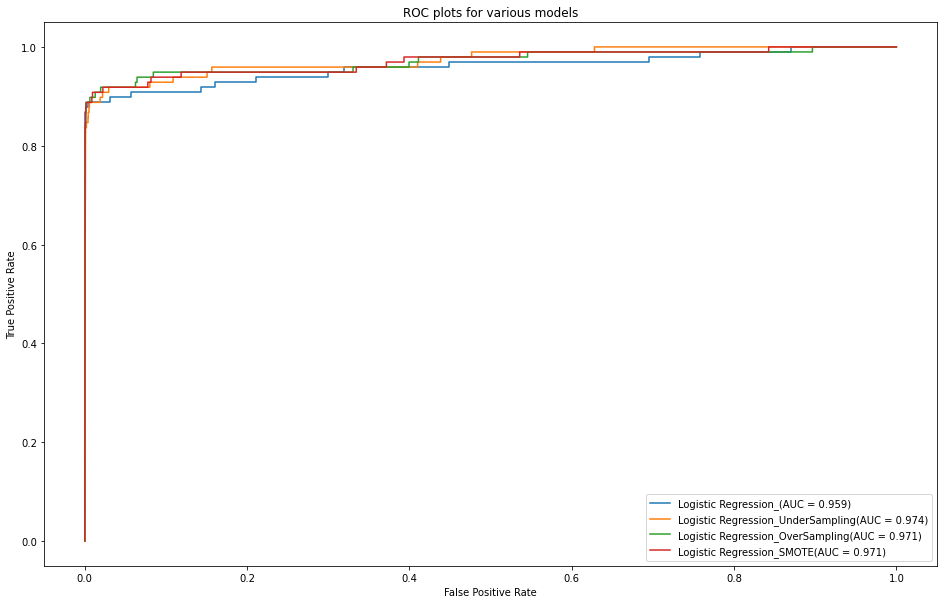

In [20]:
# Your Code Here
y_pred=scores_logReg['estimator'][log_best_index].predict_proba(X_test)
fpr,tpr,_=roc_curve(y_test,y_pred[:,1])
plt.figure(figsize = (16,10))
roc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="Logistic Regression_(AUC = %0.3f)" % roc_score)

y_pred=scores_under['estimator'][under_best_index].predict_proba(X_test)
fpr,tpr,_=roc_curve(y_test,y_pred[:,1])
roc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="Logistic Regression_UnderSampling(AUC = %0.3f)" % roc_score)

y_pred=scores_over['estimator'][over_best_index].predict_proba(X_test)
fpr,tpr,_=roc_curve(y_test,y_pred[:,1])
roc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="Logistic Regression_OverSampling(AUC = %0.3f)" % roc_score)

y_pred=scores_smote['estimator'][smote_best_index].predict_proba(X_test)
fpr,tpr,_=roc_curve(y_test,y_pred[:,1])
roc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="Logistic Regression_SMOTE(AUC = %0.3f)" % roc_score)
plt.title("ROC plots for various models")
plt.xlabel("False Positive Rate")
plt.legend()
plt.ylabel("True Positive Rate")

We see that for lower values of False positive rate the Sampled versions of logistic regression perform better and for higher values the vanilla logistic regression does the better job.Hence, ROC curves do not give the full picture for imbalanced datasets and we need to look into the PR curves to get the best model.ROC curves may have high values even if it mis classifies the minority data sets and hence there is a need to look at PR curves.

**Q10. Plot the precision-recall curve for all four models above in a single plot. Make sure to label the axes and legend. Comment on your result.**

Text(0, 0.5, 'Precision')

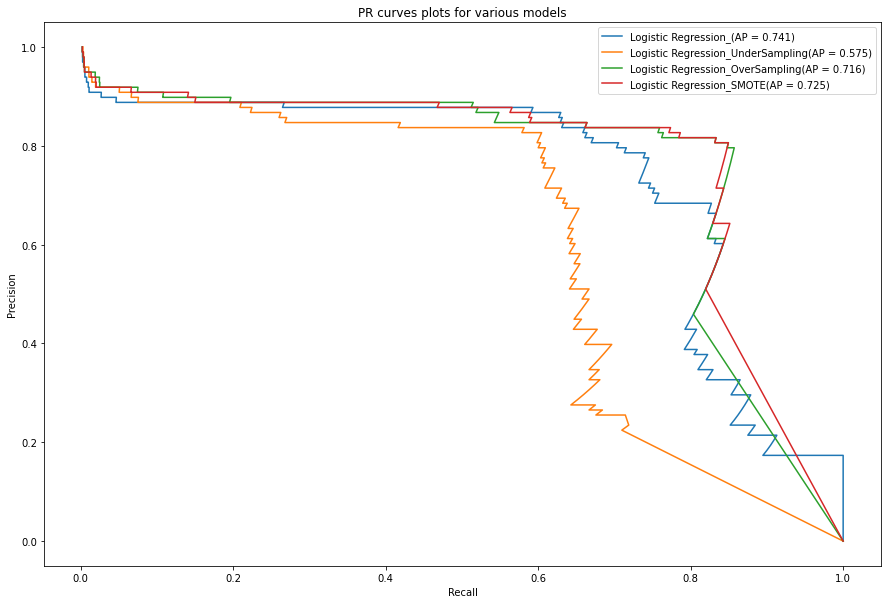

In [21]:
# Your Code Here
y_pred=scores_logReg['estimator'][log_best_index].predict_proba(X_test)
fpr,tpr,_=precision_recall_curve(y_test,y_pred[:,1])
plt.figure(figsize = (15,10))
avg_score=average_precision_score(y_test,y_pred[:,1])
plt.plot(fpr, tpr, label="Logistic Regression_(AP = %0.3f)" % avg_score)


y_pred=scores_under['estimator'][under_best_index].predict_proba(X_test)
fpr,tpr,_=precision_recall_curve(y_test,y_pred[:,1])
avg_score=average_precision_score(y_test,y_pred[:,1])
plt.plot(fpr, tpr, label="Logistic Regression_UnderSampling(AP = %0.3f)" % avg_score)

y_pred=scores_over['estimator'][over_best_index].predict_proba(X_test)
fpr,tpr,_=precision_recall_curve(y_test,y_pred[:,1])
avg_score=average_precision_score(y_test,y_pred[:,1])
plt.plot(fpr, tpr, label="Logistic Regression_OverSampling(AP = %0.3f)" % avg_score)

y_pred=scores_smote['estimator'][smote_best_index].predict_proba(X_test)
fpr,tpr,_=precision_recall_curve(y_test,y_pred[:,1])
avg_score=average_precision_score(y_test,y_pred[:,1])
plt.plot(fpr, tpr, label="Logistic Regression_SMOTE(AP = %0.3f)" % avg_score)

plt.title("PR curves plots for various models")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

Average precision of models are high when it can handle prediction of minority class better without accidently marking too many negative samples as positives.
In this case we see that for various sampling methods there is a increase in the recall, and since recall and precision are metrics that are opposing in this case, there will be a decrease precision.Hence we see that for sampling techniques the Average precision is lower than the vanilla logistic regression. In the case of undersampling we see that the value is less than all since it also has the highest number of false positives and this affects the precision a lot and hence it has the least average precision.

**Q11. Adding class weights to a logistic regression model. Print the AUC and average precision of 5-fold cross validation. Also, plot its confusion matrix on test set.**

In [22]:
# Your Code Here
scores_logReg_balanced= cross_validate(LogisticRegression(class_weight='balanced'),
                       X_dev,y_dev,cv=5,
                       scoring=['roc_auc','average_precision'],
                       return_estimator= True)
print(f"AUC score-{scores_logReg_balanced['test_roc_auc']}")
print(f"Average Precision score-{scores_logReg_balanced['test_average_precision']}")
print(f"Mean AUC score-{scores_logReg_balanced['test_roc_auc'].mean()}")
print(f"Mean Average Precision score-{scores_logReg_balanced['test_average_precision'].mean()}")

AUC score-[0.95940194 0.9812208  0.98718789 0.98181545 0.9934096 ]
Average Precision score-[0.67349952 0.7989738  0.77374577 0.75041294 0.76400025]
Mean AUC score-0.9806071364184955
Mean Average Precision score-0.7521264537120119


In this case there are 5 models with the scores of each for various metrics as shown above. We select the model for further study based on the model that gave us the maximum AUC score. Given this assumption, we calculate and check to get the index of the best model from the given set of 5 models.

In [23]:
log_balanced_best_index= np.argmax(scores_logReg_balanced['test_roc_auc'])
log_balanced_best_index

4

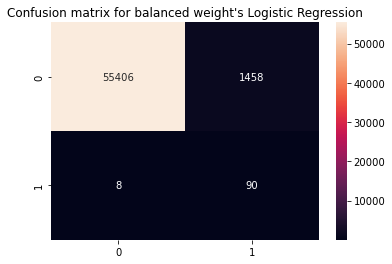

In [24]:
y_pred=scores_logReg_balanced['estimator'][log_balanced_best_index].predict(X_test)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='g')
plt.title("Confusion matrix for balanced weight's Logistic Regression")
plt.show()

**Q12. Plot the ROC and the precision-recall curve for default Logistic without any sampling method and this balanced Logistic model in two single plots. Make sure to label the axes and legend. Comment on your result.**

Text(0, 0.5, 'True Positive Rate')

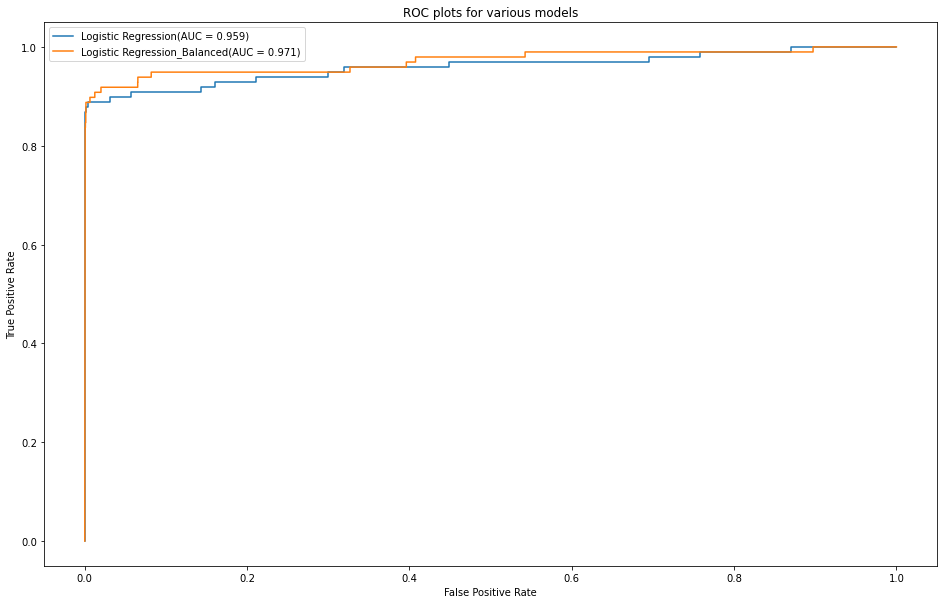

In [25]:
# Your Code Here
y_pred=scores_logReg['estimator'][log_best_index].predict_proba(X_test)
fpr,tpr,_=roc_curve(y_test,y_pred[:,1])
plt.figure(figsize = (16,10))
roc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="Logistic Regression(AUC = %0.3f)" % roc_score)

y_pred=scores_logReg_balanced['estimator'][log_balanced_best_index].predict_proba(X_test)
fpr,tpr,_=roc_curve(y_test,y_pred[:,1])
roc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="Logistic Regression_Balanced(AUC = %0.3f)" % roc_score)
plt.title("ROC plots for various models")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Text(0, 0.5, 'Precision')

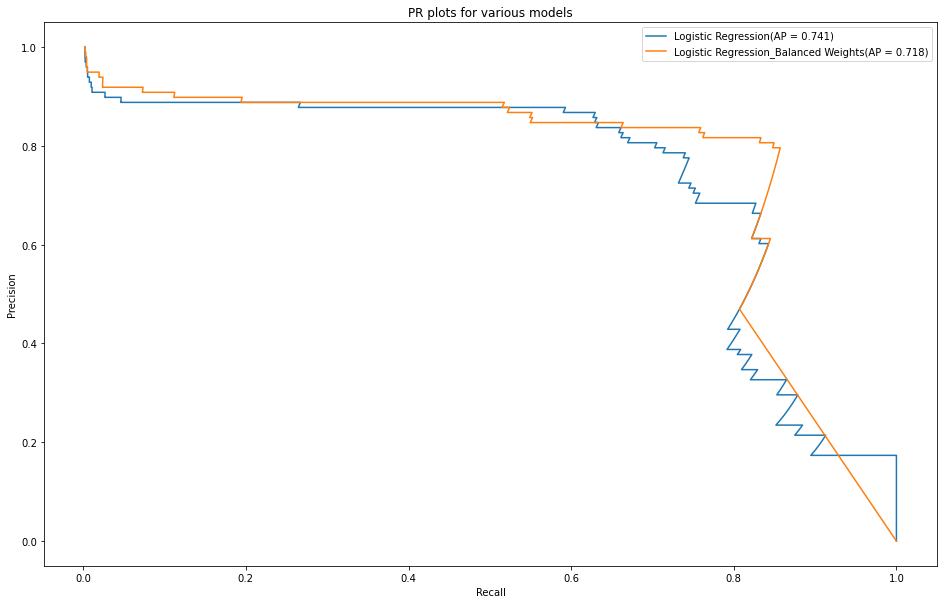

In [26]:
y_pred=scores_logReg['estimator'][log_best_index].predict_proba(X_test)
fpr,tpr,_=precision_recall_curve(y_test,y_pred[:,1])
plt.figure(figsize = (16,10))
avg_score=average_precision_score(y_test,y_pred[:,1])
plt.plot(fpr, tpr, label="Logistic Regression(AP = %0.3f)" % avg_score)

y_pred=scores_logReg_balanced['estimator'][log_balanced_best_index].predict_proba(X_test)
fpr,tpr,_=precision_recall_curve(y_test,y_pred[:,1])
avg_score=average_precision_score(y_test,y_pred[:,1])
plt.plot(fpr, tpr, label="Logistic Regression_Balanced Weights(AP = %0.3f)" % avg_score)

plt.title("PR plots for various models")
plt.legend()
plt.xlabel("Recall") 
plt.ylabel("Precision")


In balanced weights case for logistic regression, we modify the loss function to account for the class weights. This results in having an effect similar to oversampling. Hence we again see that the PR curve helps us in understanding the problem better. As said previously, the recall should be increased for our problem of fraud detection and this in turn reduces our precision. Hence we see that the Average precision of logistic regression with balance class weights is lower than the vanilla regression. 

## Part 2: Unsupervised Learning

In this part, we will be applying unsupervised learning approaches to a problem in computational biology. Specifically, we will be analyzing single-cell genomic sequencing data. Single-cell genomics is a set of revolutionary new technologies which can profile the genome of a specimen (tissue, blood, etc.) at the resolution of individual cells. This increased granularity can help capture intercellular heterogeneity, key to better understanding and treating complex genetic diseases such as cancer and Alzheimer's. 

<img src="https://cdn.10xgenomics.com/image/upload/v1574196658/blog/singlecell-v.-bulk-image.png" width="800px"/>

<center>Source: 10xgenomics.com/blog/single-cell-rna-seq-an-introductory-overview-and-tools-for-getting-started</center>

A common challenge of genomic datasets is their high-dimensionality: a single observation (a cell, in the case of single-cell data) may have tens of thousands of gene expression features. Fortunately, biology offers a lot of structure - different genes work together in pathways and are co-regulated by gene regulatory networks. Unsupervised learning is widely used to discover this intrinsic structure and prepare the data for further analysis.

### Dataset: single-cell RNASeq of mouse brain cells

We will be working with a single-cell RNASeq dataset of mouse brain cells. In the following gene expression matrix, each row represents a cell and each column represents a gene. Each entry in the matrix is a normalized gene expression count - a higher value means that the gene is expressed more in that cell. The dataset has been pre-processed using various quality control and normalization methods for single-cell data. 

Data source is on Coursework.

In [27]:
cell_gene_counts_df = pd.read_csv('mouse_brain_cells_gene_counts.csv', index_col='cell')
cell_gene_counts_df

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.08093,0.7856,1.334,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.567
A1.B003728.3_56_F.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.8350,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,-0.681
A1.MAA000560.3_10_M.1.1,-0.08093,0.6300,-0.576,-0.2727,-0.4153,-0.2084,-0.4692,-0.03146,-0.6035,1.253000,...,1.3150,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,2.072,-0.5654,-0.04385,1.260
A1.MAA000564.3_10_M.1.1,-0.08093,0.3809,1.782,-0.2727,-0.4153,1.0300,-0.4692,-0.03146,1.2640,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,2.3900,-0.553,0.1697,-0.04385,-0.681
A1.MAA000923.3_9_M.1.1,-0.08093,0.5654,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-1.021000,...,-0.7227,-0.2145,-0.1927,-0.4163,2.3180,-0.5913,-0.553,-0.5654,-0.04385,-0.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2.MAA000902.3_11_M.1.1,14.98400,1.1550,-0.576,-0.2727,-0.4153,0.7530,-0.4692,-0.03146,-0.6035,-1.021000,...,1.4260,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,1.728
E2.MAA000926.3_9_M.1.1,-0.08093,-1.4840,-0.576,-0.2727,-0.4153,1.4720,-0.4692,-0.03146,1.8120,1.079000,...,-0.7227,-0.2145,-0.1927,-0.4163,0.2422,-0.5913,-0.553,1.6060,-0.04385,-0.681
E2.MAA000932.3_11_M.1.1,-0.08093,0.5703,-0.576,-0.2727,-0.4153,-0.8310,-0.4692,-0.03146,-0.6035,-0.003473,...,-0.7227,-0.2145,-0.1927,-0.4163,-0.5923,-0.5913,-0.553,-0.5654,-0.04385,2.074


Note the dimensionality - we have 1000 cells (observations) and 18,585 genes (features)!

We are also provided a metadata file with annotations for each cell (e.g. cell type, subtissue, mouse sex, etc.)

In [28]:
cell_metadata_df = pd.read_csv('mouse_brain_cells_metadata.csv')
cell_metadata_df

,cell,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
0,A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
1,A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
2,A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
3,A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
4,A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0
...,...,...,...,...,...,...,...,...
995,E2.MAA000902.3_11_M.1.1,astrocyte,Striatum,M,3_11_M,MAA000902,3026,3134463.0
996,E2.MAA000926.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000926,3085,744301.0
997,E2.MAA000932.3_11_M.1.1,endothelial cell,Hippocampus,M,3_11_M,MAA000932,2277,519257.0
998,E2.MAA000944.3_9_M.1.1,oligodendrocyte,Cortex,M,3_9_M,MAA000944,3234,1437895.0


Different cell types

In [29]:
cell_metadata_df['cell_ontology_class'].value_counts()

oligodendrocyte                   385
endothelial cell                  264
astrocyte                         135
neuron                             94
brain pericyte                     58
oligodendrocyte precursor cell     54
Bergmann glial cell                10
Name: cell_ontology_class, dtype: int64

Different subtissue types (parts of the brain)

In [30]:
cell_metadata_df['subtissue'].value_counts()

Cortex         364
Hippocampus    273
Striatum       220
Cerebellum     143
Name: subtissue, dtype: int64

Our goal in this exercise is to use dimensionality reduction and clustering to visualize and better understand the high-dimensional gene expression matrix. We will use the following pipeline, which is common in single-cell analysis:
1. Use PCA to project the gene expression matrix to a lower-dimensional linear subspace.
2. Cluster the data using K-means on the first 20 principal components.
3. Use t-SNE to project the first 20 principal components onto two dimensions. Visualize the points and color by their clusters from (2).

## 1 PCA

**Q1. Perform PCA and project the gene expression matrix onto its first 50 principal components. You may use `sklearn.decomposition.PCA`.**

In [31]:
### Your code here
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(cell_gene_counts_df)
principal_df = pd.DataFrame(data = principalComponents)
principal_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,15.353967,22.551441,28.909568,18.160744,-63.669863,63.397358,22.120396,193.168081,5.079504,-12.084383,...,-2.688728,4.278716,2.501388,-2.737604,4.074391,-7.426862,14.521051,-10.303405,5.771961,-8.855646
1,-19.092789,-3.011189,37.073015,-7.781964,-0.324304,-5.520998,1.450258,-0.053575,-2.177475,3.883173,...,-0.456695,0.568156,-0.088209,-0.805724,0.273058,0.243853,0.057334,-2.158787,0.950795,-0.520753
2,1.624026,-26.093832,-8.735882,1.431624,3.908802,-0.872087,-2.047060,2.420201,3.514804,3.970469,...,1.125755,-0.294077,0.637617,1.415364,-0.324992,-0.508422,0.912139,0.305792,-0.314381,0.423605
3,-15.469770,37.906454,-37.408305,5.952024,-10.229874,4.293255,15.286259,-4.262441,-6.748092,6.366285,...,2.755248,-2.808042,1.471948,-1.993401,2.559400,-1.939815,-0.451967,-8.260533,-0.995563,-2.340308
4,-15.223271,-2.999145,38.531674,-6.379689,-6.113620,-4.637019,5.044908,-2.089755,-6.841558,3.252719,...,-0.737250,-1.465855,-1.955867,-1.040151,0.542152,1.137555,-1.250162,-0.692033,-0.514267,0.961177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-3.155956,-3.599854,36.290781,-5.177448,-19.399648,0.435055,11.439437,-9.045928,-15.710149,9.538594,...,-0.950550,-1.808793,-0.852989,-2.822190,-2.105215,0.239304,0.112026,0.149888,-1.141942,-0.990834
996,-1.474810,-25.927919,-4.133709,0.153575,6.328284,-2.617471,-2.451736,3.187181,1.757379,-3.302491,...,0.076969,-0.455273,-0.821334,-0.372883,-0.805361,0.334695,0.953723,-0.550713,-0.117394,0.865780
997,-28.401428,19.681180,-7.704601,-1.473941,6.044442,-5.930665,3.987709,1.741066,-1.530253,-4.954080,...,-2.026786,-0.894644,0.684194,-2.168486,-0.192080,0.791475,-1.274422,-5.501073,0.602797,1.215534
998,4.029614,-30.038009,-7.426854,1.246195,3.455532,-0.855075,-1.850935,1.335378,-1.726069,-3.373511,...,0.073791,0.291790,1.382496,0.895376,-0.207703,0.130327,-0.721511,-0.364301,0.080298,-0.754534


**Q2. Plot the cumulative proportion of variance explained as a function of the number of principal components. How much of the total variance in the dataset is explained by the first 20 principal components?**

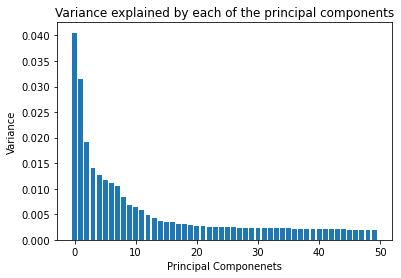

In [32]:
### Your code here
fig = plt.figure()
plt.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
plt.xlabel('Principal Componenets')
plt.ylabel('Variance')
plt.title('Variance explained by each of the principal components')
plt.show()

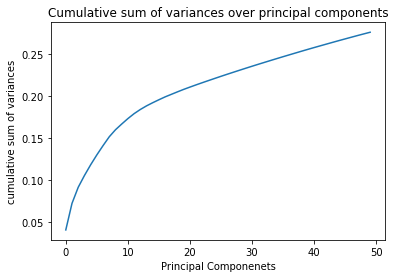

The first 20 principal components capture a total variance of 20.765358614185114 %


In [33]:
fig = plt.figure()
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Componenets')
plt.ylabel('cumulative sum of variances')
plt.title('Cumulative sum of variances over principal components')
plt.show()
print(f'The first 20 principal components capture a total variance of {sum(pca.explained_variance_ratio_[0:20])*100} %')

**Q3. For the first principal component, report the top 10 loadings (weights) and their corresponding gene names.** In other words, which 10 genes are weighted the most in the first principal component?

In [34]:
### Your code here
weights= pca.components_[0,:]
top_10_genes=sorted(range(len(weights)), key=lambda i: weights[i], reverse=True)[:10]
genes=cell_gene_counts_df.columns
top_10_genes=pd.DataFrame(data=[genes[top_10_genes],weights[top_10_genes]],index=['Genes','Weights'])
print(f'The top 10 gene names with the corresponding weights in first principal component are -')
top_10_genes.T

The top 10 gene names with the corresponding weights in first principal component are -


,Genes,Weights
0,Nsg2,0.026673
1,St8sia3,0.026595
2,Ptpn5,0.026588
3,Kcnj4,0.026539
4,Rasgef1a,0.026347
5,Camkv,0.026221
6,Hpca,0.026173
7,Cpne5,0.026022
8,Nrsn2,0.025979
9,Erc2,0.025853


**Q4. Plot the projection of the data onto the first two principal components using a scatter plot.**

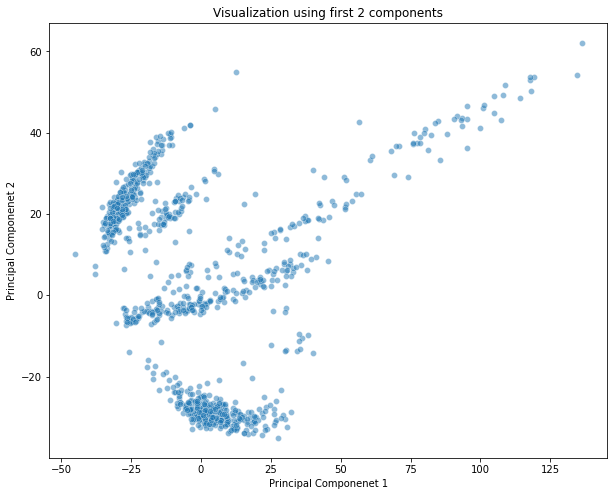

In [35]:
### Your code here
first_2_components=np.array(principal_df[[0,1]])
fig = plt.figure(figsize=(10,8))
sns.scatterplot(x=first_2_components[:,0],y=first_2_components[:,1],alpha=0.5)
plt.xlabel('Principal Componenet 1')
plt.ylabel('Principal Componenet 2')
plt.title('Visualization using first 2 components')
plt.show()

**Q5. Now, use a small multiple of four scatter plots to make the same plot as above, but colored by four annotations in the metadata: cell_ontology_class, subtissue, mouse.sex, mouse.id. Include a legend for the labels.** For example, one of the plots should have points projected onto PC 1 and PC 2, colored by their cell_ontology_class.

In [36]:
### Your code here
classes=['cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id']
class_df=cell_metadata_df[classes]
cord_df = pd.DataFrame(data=first_2_components)
cord_df.columns = ['cord1', 'cord2']
plot_df = pd.concat([cord_df, class_df], axis=1, join='inner')
plot_df  

,cord1,cord2,cell_ontology_class,subtissue,mouse.sex,mouse.id
0,15.353967,22.551441,astrocyte,Striatum,F,3_38_F
1,-19.092789,-3.011189,astrocyte,Striatum,F,3_56_F
2,1.624026,-26.093832,oligodendrocyte,Cortex,M,3_10_M
3,-15.469770,37.906454,endothelial cell,Striatum,M,3_10_M
4,-15.223271,-2.999145,astrocyte,Hippocampus,M,3_9_M
...,...,...,...,...,...,...
995,-3.155956,-3.599854,astrocyte,Striatum,M,3_11_M
996,-1.474810,-25.927919,oligodendrocyte,Cortex,M,3_9_M
997,-28.401428,19.681180,endothelial cell,Hippocampus,M,3_11_M
998,4.029614,-30.038009,oligodendrocyte,Cortex,M,3_9_M


<AxesSubplot:title={'center':'mouse.id'}, xlabel='cord1', ylabel='cord2'>

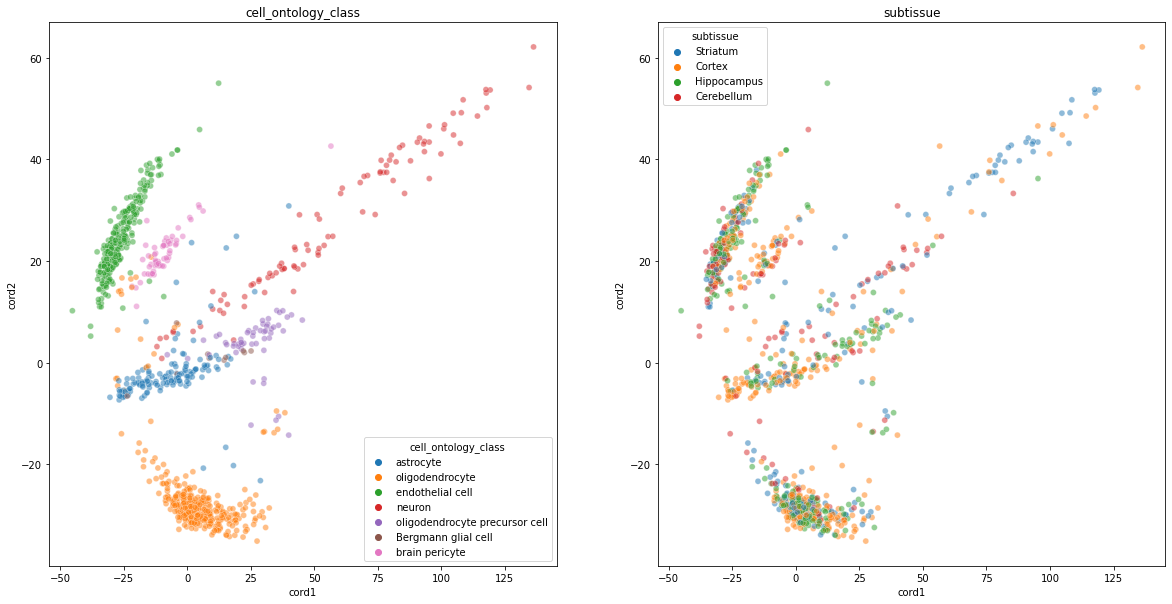

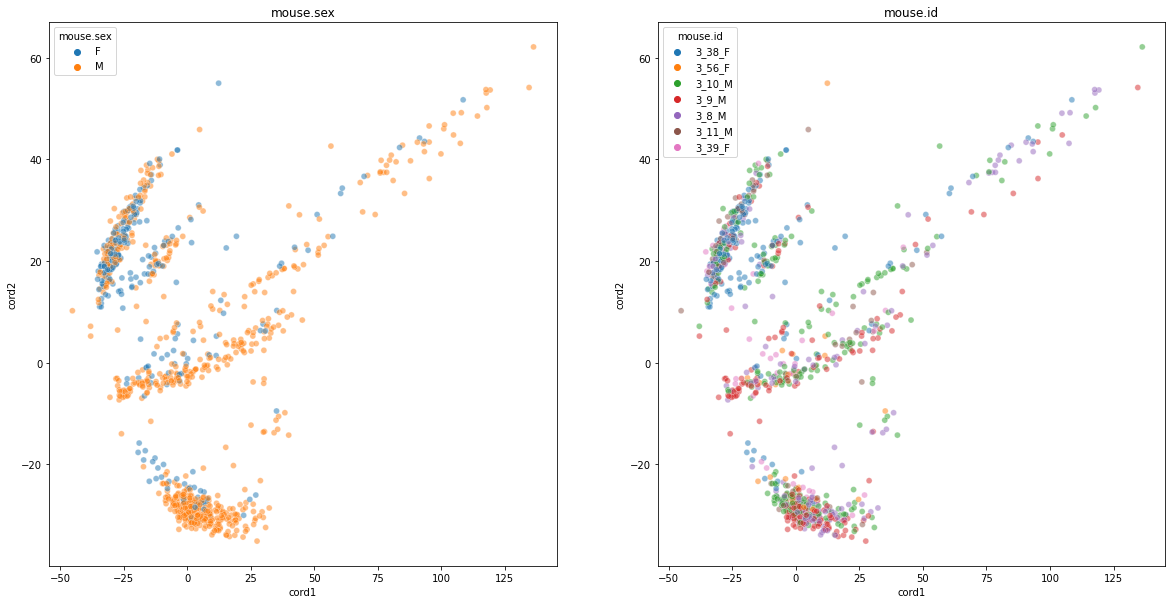

In [37]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.set_title(classes[0])
sns.scatterplot(x='cord1', y='cord2', data=plot_df, ax=ax1,hue=classes[0],alpha =0.5)

ax2.set_title(classes[1])
sns.scatterplot(x='cord1', y='cord2', data=plot_df, ax=ax2,hue=classes[1],alpha =0.5)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.set_title(classes[2])
sns.scatterplot(x='cord1', y='cord2', data=plot_df, ax=ax1,hue=classes[2],alpha =0.5)

ax2.set_title(classes[3])
sns.scatterplot(x='cord1', y='cord2', data=plot_df, ax=ax2,hue=classes[3],alpha =0.5)


**Q6. Based on the plots above, the first two principal components correspond to which aspect of the cells? What is the intrinsic dimension that they are describing?**

### Your answer here

These two dimensions principal components describe the cell ontology class. They are able to describe the various classes of the cell ontology class such as astrocyte, aligodendrocyte etc.

## 2 K-means

While the annotations provide high-level information on cell type (e.g. cell_ontology_class has 7 categories), we may also be interested in finding more granular subtypes of cells. To achieve this, we will use K-means clustering to find a large number of clusters in the gene expression dataset. Note that the original gene expression matrix had over 18,000 noisy features, which is not ideal for clustering. So, we will perform K-means clustering on the first 20 principal components of the dataset.

**Q7. Implement a `kmeans` function which takes in a dataset `X` and a number of clusters `k`, and returns the cluster assignment for each point in `X`. You may NOT use sklearn for this implementation. Use lecture 6, slide 14 as a reference.**

In [38]:
def kmeans(X, k, iters=10):
    '''Groups the points in X into k clusters using the K-means algorithm.

    Parameters
    ----------
    X : (m x n) data matrix
    k: number of clusters
    iters: number of iterations to run k-means loop

    Returns
    -------
    y: (m x 1) cluster assignment for each point in X
    '''
    ### Your code here
    #Randomly choosing Centroids 
    idx = np.random.choice(len(X), k, replace=False)
    centroids = X[idx, :] 
     
    #finding the distance between centroids and all the data points
    distances = cdist(X, centroids ,'euclidean') 
    points = np.array([np.argmin(i) for i in distances]) 

    for _ in range(iters): 
        centroids = []
        for idx in range(k):
            temp_cent = X[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) 
        distances = cdist(X, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points

Before applying K-means on the gene expression data, we will test it on the following synthetic dataset to make sure that the implementation is working.

/Users/rakshithkamath/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$x_2$')

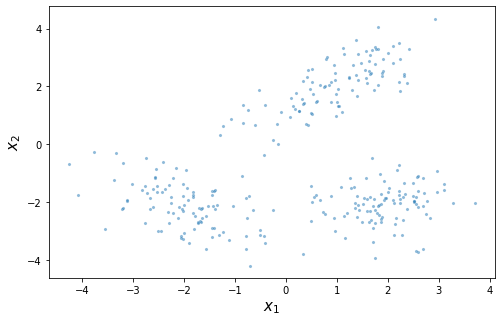

In [39]:
np.random.seed(0)
x_1 = np.random.multivariate_normal(mean=[1, 2], cov=np.array([[0.8, 0.6], [0.6, 0.8]]), size=100)
x_2 = np.random.multivariate_normal(mean=[-2, -2], cov=np.array([[0.8, -0.4], [-0.4, 0.8]]), size=100)
x_3 = np.random.multivariate_normal(mean=[2, -2], cov=np.array([[0.4, 0], [0, 0.4]]), size=100)
X = np.vstack([x_1, x_2, x_3])

plt.figure(figsize=(8, 5))
sns.scatterplot(X[:, 0], X[:, 1], s=10,alpha =0.5)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)

**Q8. Apply K-means with k=3 to the synthetic dataset above. Plot the points colored by their K-means cluster assignments to verify that your implementation is working.**

Text(0.5, 1.0, 'k-means classification for synthetic dataset')

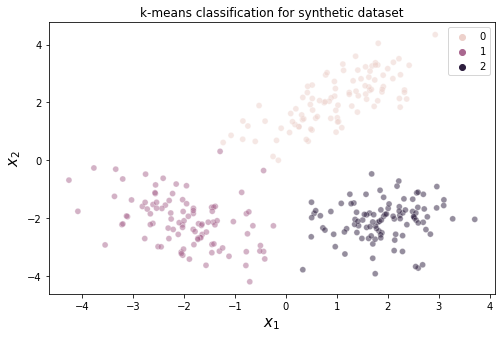

In [40]:
### Your code here
classes=kmeans(X, 3, iters=100)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X[:, 0], y= X[:, 1],hue=classes,alpha =0.5)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('k-means classification for synthetic dataset')

**Q9. Use K-means with k=20 to cluster the first 20 principal components of the gene expression data.**

In [41]:
### Your code here
principal_20_df=principal_df.iloc[:,0:20]
principal_20_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,15.353967,22.551441,28.909568,18.160744,-63.669863,63.397358,22.120396,193.168081,5.079504,-12.084383,-6.772628,-10.375092,-3.773919,7.348799,29.255171,-82.118741,-34.964775,20.096488,-43.932843,-136.886174
1,-19.092789,-3.011189,37.073015,-7.781964,-0.324304,-5.520998,1.450258,-0.053575,-2.177475,3.883173,3.891347,-1.154655,-5.804449,2.191769,6.295381,1.490762,3.912787,0.263424,-0.173075,-0.360113
2,1.624026,-26.093832,-8.735882,1.431624,3.908802,-0.872087,-2.047060,2.420201,3.514804,3.970469,0.178141,-0.661343,-4.577087,0.316287,2.754474,0.213692,3.229631,-0.871809,-0.548675,0.408724
3,-15.469770,37.906454,-37.408305,5.952024,-10.229874,4.293255,15.286259,-4.262441,-6.748092,6.366285,-0.890017,3.890429,-1.964209,6.838754,4.471379,-0.043654,-0.965937,-2.812642,2.104714,-0.938185
4,-15.223271,-2.999145,38.531674,-6.379689,-6.113620,-4.637019,5.044908,-2.089755,-6.841558,3.252719,6.328022,4.271571,2.166127,-1.067170,-0.823096,0.308780,-1.377531,-0.045824,-0.570374,-1.110141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-3.155956,-3.599854,36.290781,-5.177448,-19.399648,0.435055,11.439437,-9.045928,-15.710149,9.538594,8.283811,7.246334,-1.875839,-1.315230,0.050303,-1.131396,-1.359062,-3.922346,0.547247,-0.673731
996,-1.474810,-25.927919,-4.133709,0.153575,6.328284,-2.617471,-2.451736,3.187181,1.757379,-3.302491,0.698289,1.000392,6.484820,-2.113700,-3.362245,-0.407479,-3.130147,2.005601,0.026443,-1.055932
997,-28.401428,19.681180,-7.704601,-1.473941,6.044442,-5.930665,3.987709,1.741066,-1.530253,-4.954080,2.411948,0.261447,5.298877,-0.394621,-2.971455,-0.066533,-2.706228,0.439228,0.169660,-0.040410
998,4.029614,-30.038009,-7.426854,1.246195,3.455532,-0.855075,-1.850935,1.335378,-1.726069,-3.373511,0.329634,1.447707,4.311709,-1.577954,-1.801756,-0.431749,-1.745544,1.109496,-1.122371,-0.586704


Text(0.5, 1.0, 'Number of datapoints assigned to each class from class 0 to class 19')

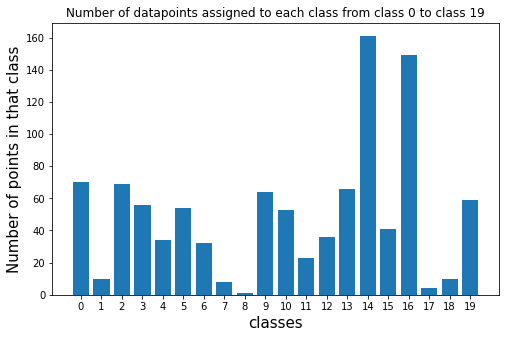

In [42]:
classes=kmeans(np.array(principal_20_df), 20, iters=100)
plt.figure(figsize=(8, 5))
plt.bar(range(len(np.bincount(classes))),np.bincount(classes))
plt.xlabel('classes', fontsize=15)
plt.xticks(np.arange(0,20,1))
plt.ylabel('Number of points in that class', fontsize=15)
plt.title('Number of datapoints assigned to each class from class 0 to class 19')

## 3 t-SNE

In this final section, we will visualize the data again using t-SNE - a non-linear dimensionality reduction algorithm. You can learn more about t-SNE in this interactive tutorial: https://distill.pub/2016/misread-tsne/.

**Q10. Use t-SNE to reduce the first 20 principal components of the gene expression dataset to two dimensions. You may use `sklearn.manifold.TSNE`.** Note that it is recommended to first perform PCA before applying t-SNE to suppress noise and speed up computation.

In [43]:
### Your code here
tsne = TSNE(n_components=2, verbose=1, random_state=123)
t_sne_2 = tsne.fit_transform(principal_20_df)

/Users/rakshithkamath/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rakshithkamath/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.137600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.349998
[t-SNE] KL divergence after 1000 iterations: 0.390714


**Q11. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions.**

In [44]:
cord_df = pd.DataFrame(data=t_sne_2)
plot_df = pd.concat([cord_df,pd.DataFrame(data=classes)], axis=1, join='inner')
plot_df.columns = ['cord1', 'cord2','class']
plot_df 

,cord1,cord2,class
0,2.489501,5.209950,13
1,-3.303194,0.481741,0
2,25.570988,16.331343,16
3,-33.592327,-33.639145,6
4,-6.094254,2.014049,0
...,...,...,...
995,-7.706818,9.356227,13
996,33.522652,29.721071,14
997,-37.579945,-17.330479,9
998,38.265717,21.025730,16


Text(0.5, 1.0, '20 principal components projected onto first two dimensions of t-SNE')

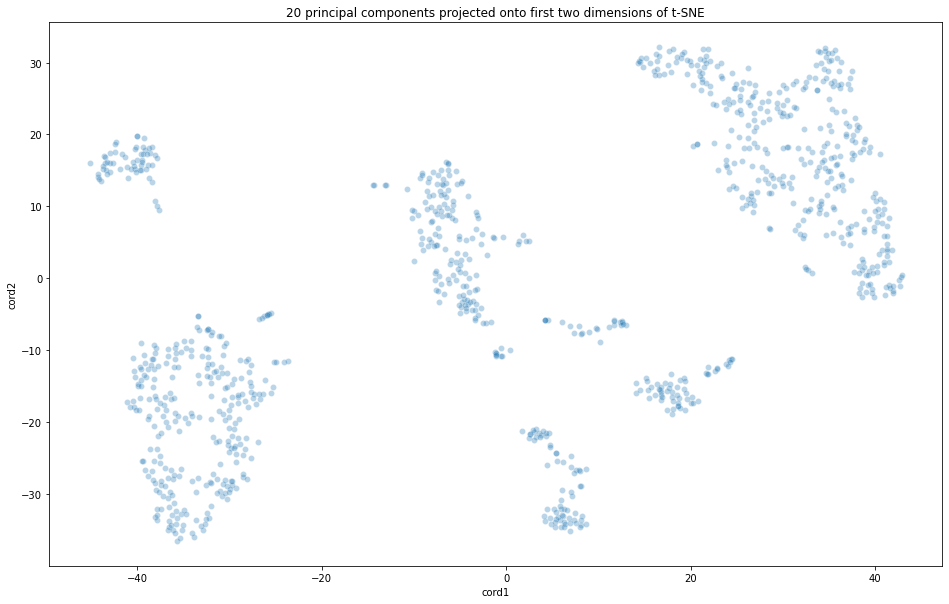

In [45]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='cord1', y='cord2',
    data=plot_df,
    legend="full",
    alpha=0.3
)
plt.title('20 principal components projected onto first two dimensions of t-SNE')

**Q12. Plot the data (first 20 principal components) projected onto the first two t-SNE dimensions, with points colored by their cluster assignments from part 2.**

Text(0.5, 1.0, "20 principal components projected onto first two dimensions of t-SNE and it's class assignments")

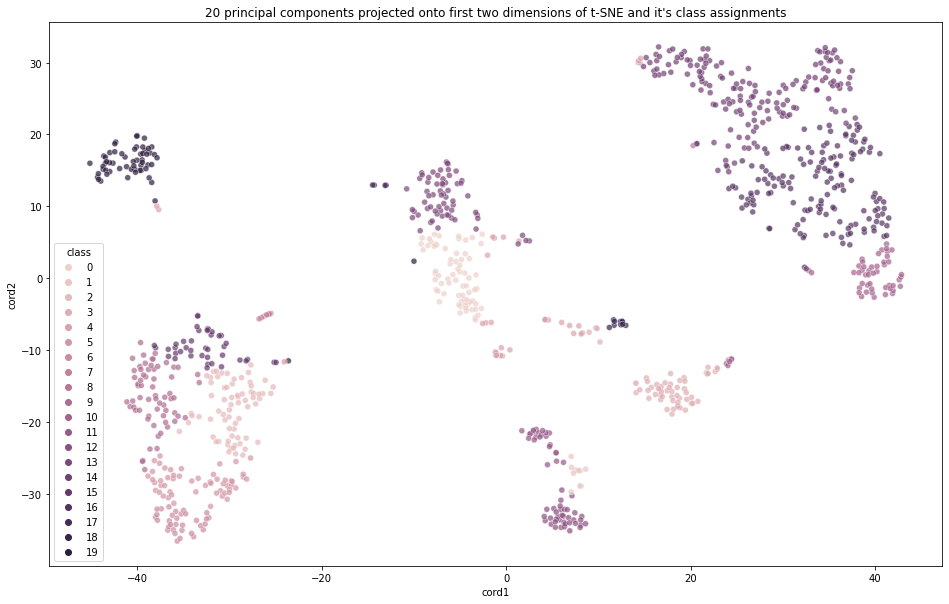

In [46]:
### Your code here
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='cord1', y='cord2',
    data=plot_df,
    hue='class',
    legend="full",
    alpha=0.7
)
plt.title("20 principal components projected onto first two dimensions of t-SNE and it's class assignments")

**Q13. Why is there overlap between points in different clusters in the t-SNE plot above?**

### Your answer here
In K-Means, all of the sample points are assigned to a unique cluster that is closest to them, and hence, there cannot be any overlap between different clusters. Had we been able to plot and color the 20 dimensional projections of PCA by their clusters, we would see no overlap in the 20-dimensional space. However, in our case, to visualize the results of K-Means, we're again projecting the projections of PCA (using PCA 20 components) to a 2-dimensional space, which will not preserve the mutual distance and positioning between these points and hence, if we were to use the same cluster labels as that of K-Means (which we ran on the projections of PCA), we are likely to see overlap. This explains the overlap between points in different clusters.

These 20 clusters may correspond to various cell subtypes or cell states. They can be further investigated and mapped to known cell types based on their gene expressions (e.g. using the K-means cluster centers). The clusters may also be used in downstream analysis. For instance, we can monitor how the clusters evolve and interact with each other over time in response to a treatment.